In [ ]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv('/content/spam.csv', encoding='latin1')

In [ ]:
df.head()

,Label,Message_body
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
df.rename(columns={'v1':'Label','v2':'Message_body'},inplace=True)
df = df.drop_duplicates(keep='first')

In [ ]:
df.shape

(5169, 2)

In [ ]:
df_train = df[:4135]
df_test = df[4135:]

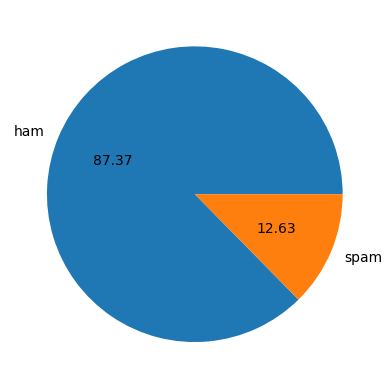

In [ ]:
import matplotlib.pyplot as plt
plt.pie(df['Label'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

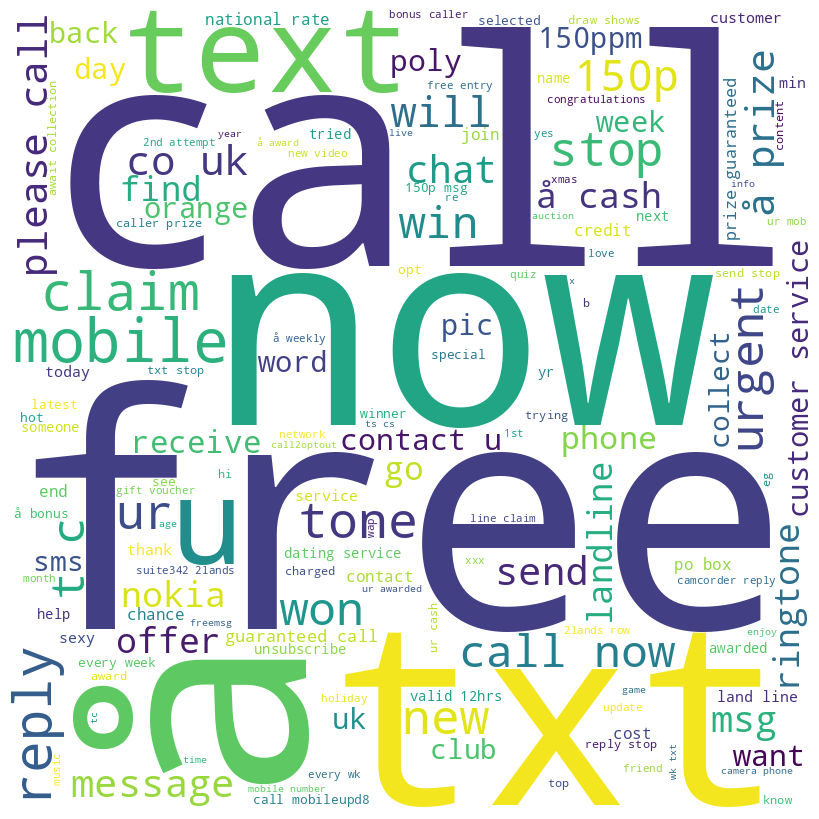

In [ ]:
df_visualize = df_train[df_train['Label'] == 'spam']


comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df_visualize['Message_body']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [ ]:
# count unique word
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

text_values = df_train['Message_body']

counter = counter_word(text_values)

In [ ]:
# Model parameter

vocab_size = len(counter)
embedding_dim = df_train['Message_body'].str.len().max()

max_length = 20

training_size = 765

In [ ]:
training_sentences = df_train['Message_body'][0:training_size]
training_labels = df_train['Label'][0:training_size]

val_sentences = df_train['Message_body'][training_size:]
val_labels = df_train['Label'][training_size:]

In [ ]:
training_labels = training_labels.replace(['spam'], 1)
training_labels = training_labels.replace(['ham'], 0)

val_labels = val_labels.replace(['spam'], 1)
val_labels = val_labels.replace(['ham'], 0)

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(training_sentences)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length)

In [ ]:
print(df_train['Message_body'][1])
print(training_sequences[1])

Ok lar... Joking wif u oni...
[49, 288, 736, 536, 8, 1157]


In [ ]:
val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, maxlen=max_length)

**Model Building**

Bidirectional LSTM

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 910)           12356890  
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               499200    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 12858171 (49.05 MB)
Trainable params: 12858171 (49.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


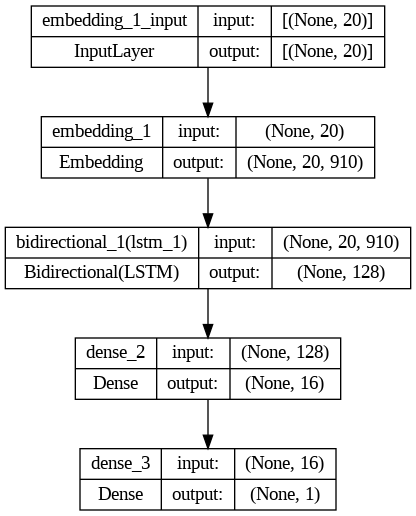

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# start training
history = model.fit(training_padded, training_labels, epochs=10, validation_data=(val_padded, val_labels))

Epoch 1/10
24/24 [==============================] - 21s 698ms/step - loss: 0.3580 - accuracy: 0.8536 - val_loss: 0.1664 - val_accuracy: 0.9531
Epoch 2/10
24/24 [==============================] - 15s 610ms/step - loss: 0.0903 - accuracy: 0.9791 - val_loss: 0.0968 - val_accuracy: 0.9697
Epoch 3/10
24/24 [==============================] - 15s 651ms/step - loss: 0.0238 - accuracy: 0.9922 - val_loss: 0.0967 - val_accuracy: 0.9754
Epoch 4/10
24/24 [==============================] - 16s 660ms/step - loss: 0.0054 - accuracy: 0.9974 - val_loss: 0.0897 - val_accuracy: 0.9754
Epoch 5/10
24/24 [==============================] - 13s 545ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0975 - val_accuracy: 0.9763
Epoch 6/10
24/24 [==============================] - 13s 532ms/step - loss: 4.6786e-04 - accuracy: 1.0000 - val_loss: 0.1058 - val_accuracy: 0.9769
Epoch 7/10
24/24 [==============================] - 13s 528ms/step - loss: 2.9168e-04 - accuracy: 1.0000 - val_loss: 0.1117 - val_accuracy

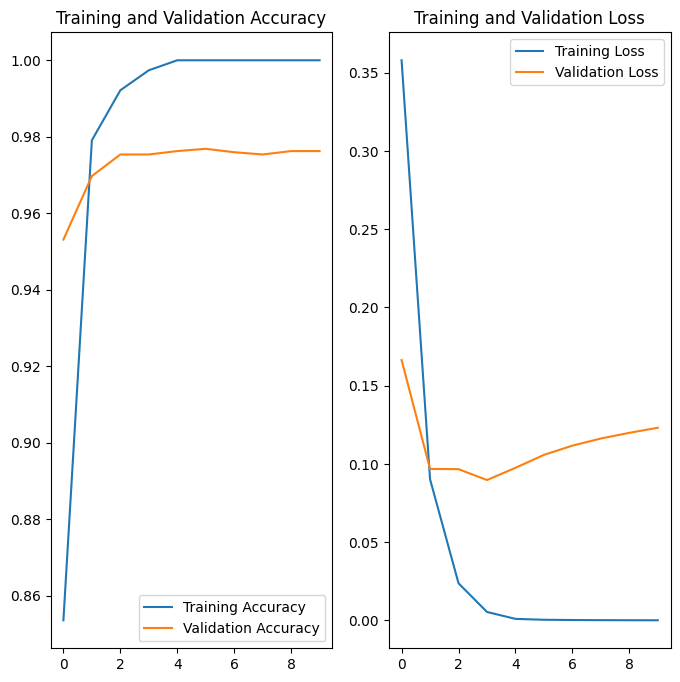

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
testing_sentences = df_test['Message_body']
testing_labels = df_test['Label']

testing_labels = testing_labels.replace(['spam'], 1)
testing_labels = testing_labels.replace(['ham'], 0)

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [ ]:
predictions = model.predict(testing_padded)

33/33 [==============================] - 2s 26ms/step


**Now Using an LSTM model**

In [ ]:
import pandas as pd
import numpy as np
import re
import collections
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

In [ ]:
df = pd.read_csv("spam.csv", encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)
df.columns = ["SpamHam","Tweet"]

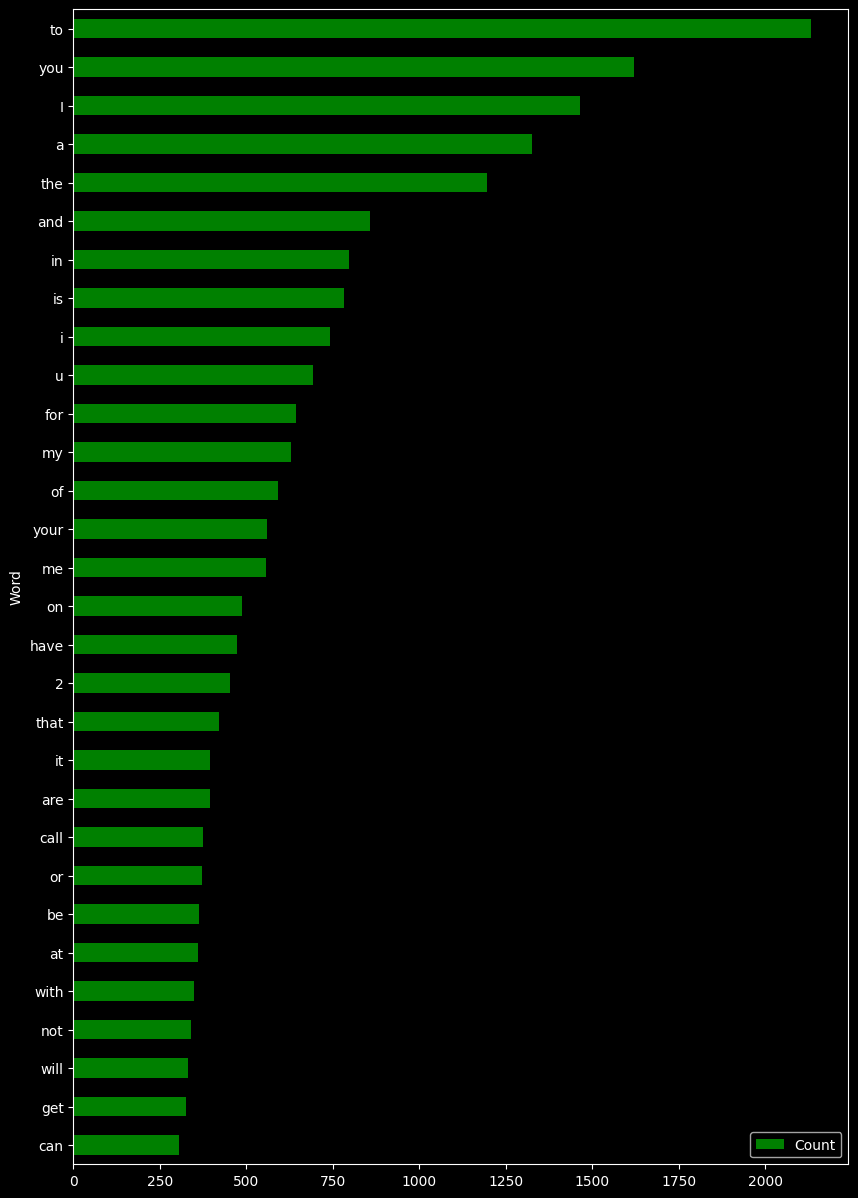

In [ ]:
def word_count_plot(data):
     # finding words along with count
     word_counter = collections.Counter([word for sentence in data for word in sentence.split()])
     most_count = word_counter.most_common(30) # 30 most common words
     # sorted data frame
     most_count = pd.DataFrame(most_count, columns=["Word", "Count"]).sort_values(by="Count")
     most_count.plot.barh(x = "Word", y = "Count", color="green", figsize=(10, 15))
word_count_plot(df["Tweet"])

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
lem = WordNetLemmatizer()
def preprocessing(data):
      sms = data
      sms = sms.lower() # lower casing the sms
      sms = re.sub(r'https?://S+|www.S+', "", sms).strip() #removing url
      sms = re.sub("[^a-z ]", "", sms) # removing symbols and numbes
      sms = sms.split() #splitting
      # lemmatization and stopword removal
      sms = [lem.lemmatize(word) for word in sms if word not in stopwords.words('english')]
      sms = " ".join(sms)
      return sms
X = df["Tweet"].apply(preprocessing)

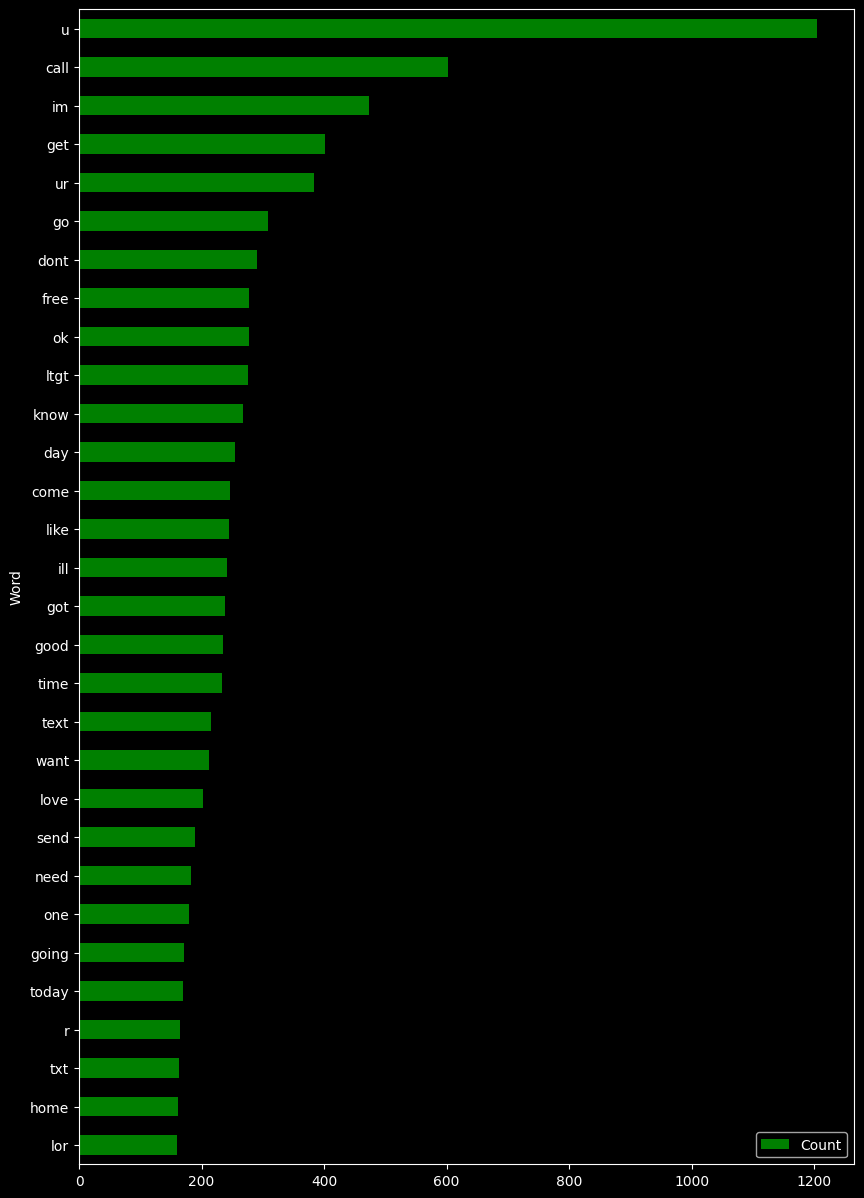

In [ ]:
word_count_plot(X)

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(df["SpamHam"])

In [ ]:
tokenizer = Tokenizer() #initializing the tokenizer
tokenizer.fit_on_texts(X)# fitting on the sms data
text_to_sequence = tokenizer.texts_to_sequences(X) # creating the numerical sequence

In [ ]:
tokenizer.index_word

{1: 'u',
 2: 'call',
 3: 'im',
 4: 'get',
 5: 'ur',
 6: 'go',
 7: 'dont',
 8: 'free',
 9: 'ok',
 10: 'ltgt',
 11: 'know',
 12: 'day',
 13: 'come',
 14: 'like',
 15: 'ill',
 16: 'got',
 17: 'good',
 18: 'time',
 19: 'text',
 20: 'want',
 21: 'love',
 22: 'send',
 23: 'need',
 24: 'one',
 25: 'going',
 26: 'today',
 27: 'r',
 28: 'txt',
 29: 'home',
 30: 'lor',
 31: 'see',
 32: 'sorry',
 33: 'stop',
 34: 'still',
 35: 'back',
 36: 'mobile',
 37: 'think',
 38: 'reply',
 39: 'n',
 40: 'take',
 41: 'tell',
 42: 'phone',
 43: 'new',
 44: 'week',
 45: 'well',
 46: 'later',
 47: 'da',
 48: 'hi',
 49: 'please',
 50: 'cant',
 51: 'make',
 52: 'say',
 53: 'night',
 54: 'claim',
 55: 'thing',
 56: 'much',
 57: 'dear',
 58: 'oh',
 59: 'great',
 60: 'hey',
 61: 'pls',
 62: 'number',
 63: 'happy',
 64: 'friend',
 65: 'work',
 66: 'give',
 67: 'hope',
 68: 'message',
 69: 'thats',
 70: 'way',
 71: 'c',
 72: 'wat',
 73: 'msg',
 74: 'prize',
 75: 'right',
 76: 'yes',
 77: 'let',
 78: 'min',
 79: 'alread

In [ ]:
max_length_sequence = max([len(i) for i in text_to_sequence])
 # finding the length of largest sequence
padded_sms_sequence = pad_sequences(text_to_sequence, maxlen=max_length_sequence,
                                    padding = "pre")
padded_sms_sequence

array([[   0,    0,    0, ...,   16, 3624,   72],
       [   0,    0,    0, ...,  349,    1, 1580],
       [   0,    0,    0, ..., 2459,  279, 2460],
       ...,
       [   0,    0,    0, ..., 1058, 7879, 3621],
       [   0,    0,    0, ...,  816,    1,    8],
       [   0,    0,    0, ..., 2192,  386,  153]], dtype=int32)

In [ ]:
TOT_SIZE = len(tokenizer.word_index)+1
def create_model():

      lstm_model = Sequential()
      lstm_model.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_model.add(LSTM(100))
      lstm_model.add(Dropout(0.4))
      lstm_model.add(Dense(20, activation="relu"))
      lstm_model.add(Dropout(0.3))
      lstm_model.add(Dense(1, activation = "sigmoid"))
      return lstm_model
lstm_model = create_model()
lstm_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [ ]:
lstm_model.fit(padded_sms_sequence, y, epochs = 10, validation_split=0.2, batch_size=16)

Epoch 1/10
279/279 [==============================] - 21s 65ms/step - loss: 0.2999 - accuracy: 0.9040 - val_loss: 0.0704 - val_accuracy: 0.9776
Epoch 2/10
279/279 [==============================] - 17s 60ms/step - loss: 0.0509 - accuracy: 0.9874 - val_loss: 0.0559 - val_accuracy: 0.9812
Epoch 3/10
279/279 [==============================] - 15s 55ms/step - loss: 0.0213 - accuracy: 0.9953 - val_loss: 0.0682 - val_accuracy: 0.9883
Epoch 4/10
279/279 [==============================] - 16s 56ms/step - loss: 0.0125 - accuracy: 0.9969 - val_loss: 0.0851 - val_accuracy: 0.9776
Epoch 5/10
279/279 [==============================] - 16s 57ms/step - loss: 0.0092 - accuracy: 0.9978 - val_loss: 0.0908 - val_accuracy: 0.9865
Epoch 6/10
279/279 [==============================] - 17s 59ms/step - loss: 0.0046 - accuracy: 0.9996 - val_loss: 0.1044 - val_accuracy: 0.9848
Epoch 7/10
279/279 [==============================] - 16s 56ms/step - loss: 9.5469e-04 - accuracy: 1.0000 - val_loss: 0.1202 - val_accur